In [1]:
!pip install yfinance tensorflow pandas numpy scikit-learn matplotlib streamlit pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 137.6 MB/s eta 0:00:00


#Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

#Fetch Data

In [9]:
# ticker( BTC-USD)
ticker = ' BTC-USD'

# Fetch data for the last 5 years
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=1825)).strftime('%Y-%m-%d')  # Approximately 5 years

print(f"Downloading data for {ticker} from {start_date} to {end_date}...")
data = yf.download(ticker, start=start_date, end=end_date)

# Use only the closing price
data = data[['Close']].copy()
data.dropna(inplace=True)

print(f"Data shape: {data.shape}")
data.head()

[*********************100%***********************]  1 of 1 completed

Data shape: (1825, 1)


Price,Close
Ticker,BTC-USD
Date,
2020-12-20,23477.294922
2020-12-21,22803.082031
2020-12-22,23783.029297
2020-12-23,23241.345703
2020-12-24,23735.949219


#Plot Historical Data

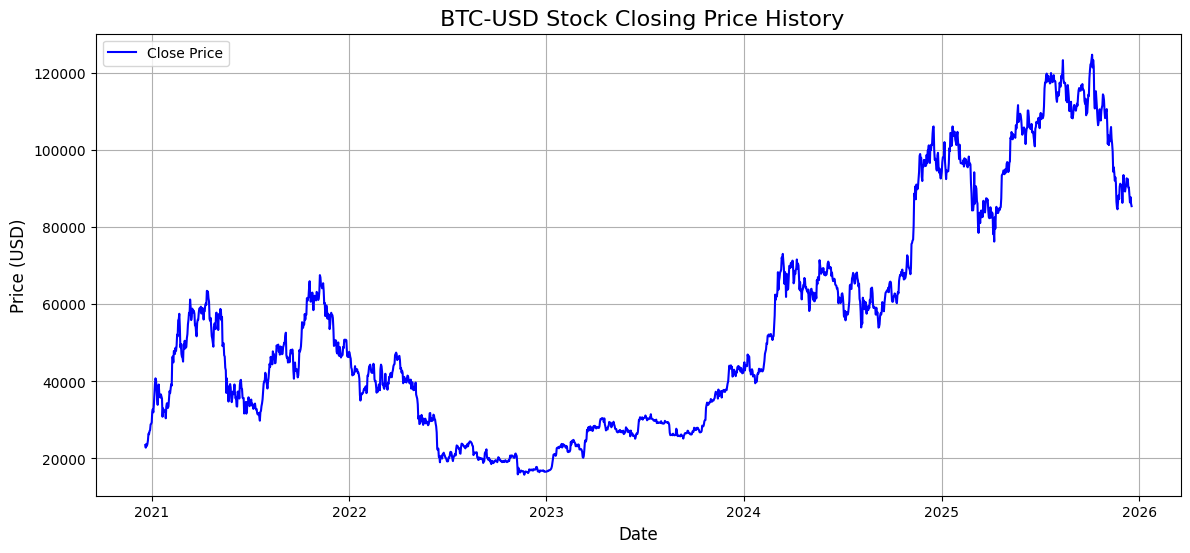

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Stock Closing Price History', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#Prepare Data for LSTM

In [5]:
# Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

# Function to create sequences (60 previous days -> predict next day)
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_data, time_step)

# Reshape for LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1765, 60, 1)
y shape: (1765,)


#Split Data (Train / Test)

In [6]:
# 80% training, 20% testing
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 1412
Testing samples: 353


#Build LSTM Model (3 Layers + Dropout)

In [7]:
model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,595 (330.45 KB)

 Trainable params: 84,595 (330.45 KB)

 Non-trainable params: 0 (0.00 B)

#Train Model with Early Stopping

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0182 - val_loss: 0.0072
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4361e-04 - val_loss: 0.0013
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/

#Plot Loss Curve

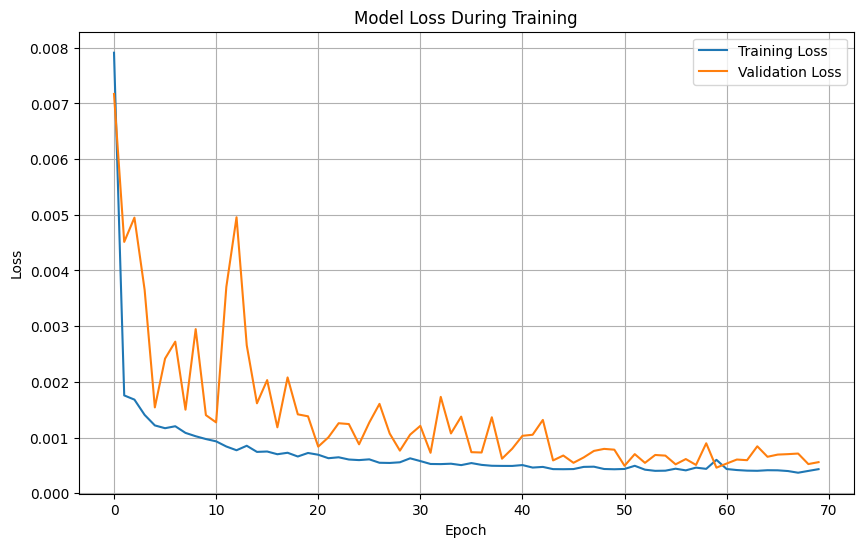

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Prediction and Evaluation

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Root Mean Squared Error (RMSE): 2502.81 USD


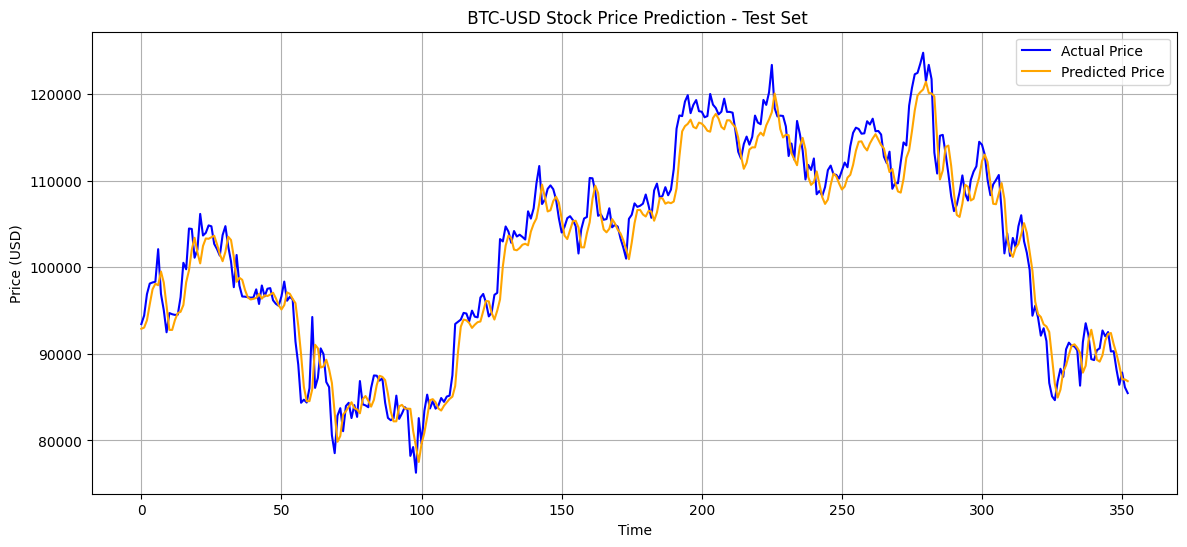

In [11]:
# Make predictions
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predicted, label='Predicted Price', color='orange')
plt.title(f'{ticker} Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

##Save Model and Scaler

In [12]:
# Save the model
model.save('lstm_stock_model.h5')
print("Model saved as lstm_stock_model.h5")

# Save the scaler for use in the application
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as scaler.pkl")

Model saved as lstm_stock_model.h5
Scaler saved as scaler.pkl


##Streamlit Code

In [13]:
%%writefile app.py
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
from datetime import datetime

# Load the model and scaler
@st.cache_resource
def load_artifacts():
    model = load_model('lstm_stock_model.h5')
    scaler = joblib.load('scaler.pkl')
    return model, scaler

model, scaler = load_artifacts()

st.title("Stock Price Prediction using LSTM")
st.markdown("### Enter a stock ticker to predict the next day's closing price")

ticker = st.text_input("Stock Ticker (e.g., AAPL, TSLA, MSFT)", value="AAPL").upper()
days = st.slider("Number of historical days to display", 365, 2000, 1000)

if st.button("Predict Next Day Price"):
    with st.spinner("Fetching data and predicting..."):
        # Fetch data
        data = yf.download(ticker, period=f"{days}d")['Close']

        if data.empty:
            st.error("Invalid ticker or no data available!")
        else:
            # Prepare last 60 days
            scaled_data = scaler.transform(data.values.reshape(-1, 1))
            last_60 = scaled_data[-60:].reshape(1, 60, 1)

            # Make prediction
            pred_scaled = model.predict(last_60)
            prediction = scaler.inverse_transform(pred_scaled)[0][0]

            latest_price = data.iloc[-1]

            st.success(f"Predicted Next Day Close Price for {ticker}: **${prediction:.2f}**")
            st.write(f"Latest Close Price: ${latest_price:.2f}")
            st.write(f"Expected Change: **{((prediction - latest_price)/latest_price*100):.2f}%**")

            # Plot historical data
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(data.index, data.values, label='Historical Close')
            ax.axvline(data.index[-1], color='gray', linestyle='--')
            ax.scatter([data.index[-1]], [latest_price], color='blue', s=100, label='Latest')
            ax.scatter([datetime.today()], [prediction], color='red', s=100, label='Predicted Next Day')
            ax.set_title(f"{ticker} Stock Price + Next Day Prediction")
            ax.legend()
            st.pyplot(fig)

Writing app.py
